<a href="https://colab.research.google.com/github/IgorRachev27/Portfolio/blob/main/Regression/LGD_competition_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Соревнование Сбера по разработке LGD модели
Loss given default (LGD) объем активов Банка, который будет утерян в случае дефолта клиента, вычисляется как доля от задолженности на момент дефолта. Для задания подготовлен ситнетический набор данных.

В рамках хакатона "ScoringDay 2021 LGD Prediction" сабмиты принимаем до 09:00 19 апреля 2021 года (время московское)

Для оценки качетсва модели испольуем метрику MAE
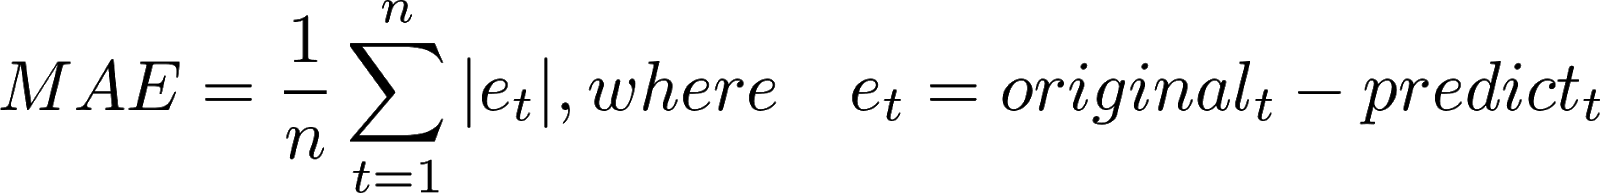


### Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from math import log
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
from sklearn import preprocessing

In [ ]:
from sklearn.preprocessing import scale, StandardScaler

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
def encoding(DF):
    encoded_data=DF.copy()
    encoders={}
    for column in encoded_data:
        if encoded_data[column].dtype==object:
            encoders[column]=preprocessing.LabelEncoder()
            encoded_data[column]=encoders[column].fit_transform(encoded_data[column])
    return encoded_data, encoders

### Подгружаем данные

In [ ]:
path="https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-train.csv"
path1="https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-test.csv"
path2="https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv"

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/LGD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv


/bin/bash: wget: command not found
/bin/bash: wget: command not found
/bin/bash: wget: command not found


In [ ]:
train_df = pd.read_csv(path, sep=';')
test_df = pd.read_csv(path1, sep=';')
desc_df = pd.read_csv(path2, sep=';')

Описание данных

In [ ]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


In [ ]:
test_df.shape

(691, 37)

Выборка содержит информацию по 2091 клиентам Банка. 1400 наблюдение в выборке для разработки 691 в тестовой выборке.

Полный список полей:

In [ ]:
train_df.columns

Index(['record_id', 'ar_revenue', 'ar_total_expenses', 'ar_sale_cost',
       'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit',
       'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes',
       'ar_other_profit_and_losses', 'ar_net_profit', 'ab_immobilized_assets',
       'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable',
       'ab_other_current_assets', 'ab_cash_and_securities', 'ab_losses',
       'ab_own_capital', 'ab_borrowed_capital', 'ab_long_term_liabilities',
       'ab_short_term_borrowing', 'ab_accounts_payable', 'ab_other_borrowings',
       'bus_age', 'ogrn_age', 'adr_actual_age', 'head_actual_age',
       'cap_actual_age', 'ul_capital_sum', 'ul_founders_cnt', 'ul_branch_cnt',
       'ul_strategic_flg', 'ul_systematizing_flg', 'ul_staff_range',
       'collateral', 'lgd'],
      dtype='object')

In [ ]:
train_df['lgd'].values.mean()

0.6333485905181601

Среднее значение LGD в выборке 63,33%

### График распределения фактического LGD

No handles with labels found to put in legend.


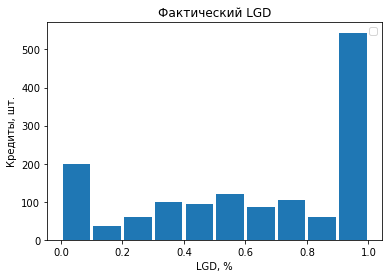

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_df['lgd'].values, histtype='bar', rwidth=0.9)
plt.xlabel('LGD, %')
plt.ylabel('Кредиты, шт.')
plt.title('Фактический LGD')
plt.legend()
plt.show()

###  Подготовка данных

<AxesSubplot:title={'center':'нулевые значения в датасете (цветное значение - нулевое)'}>

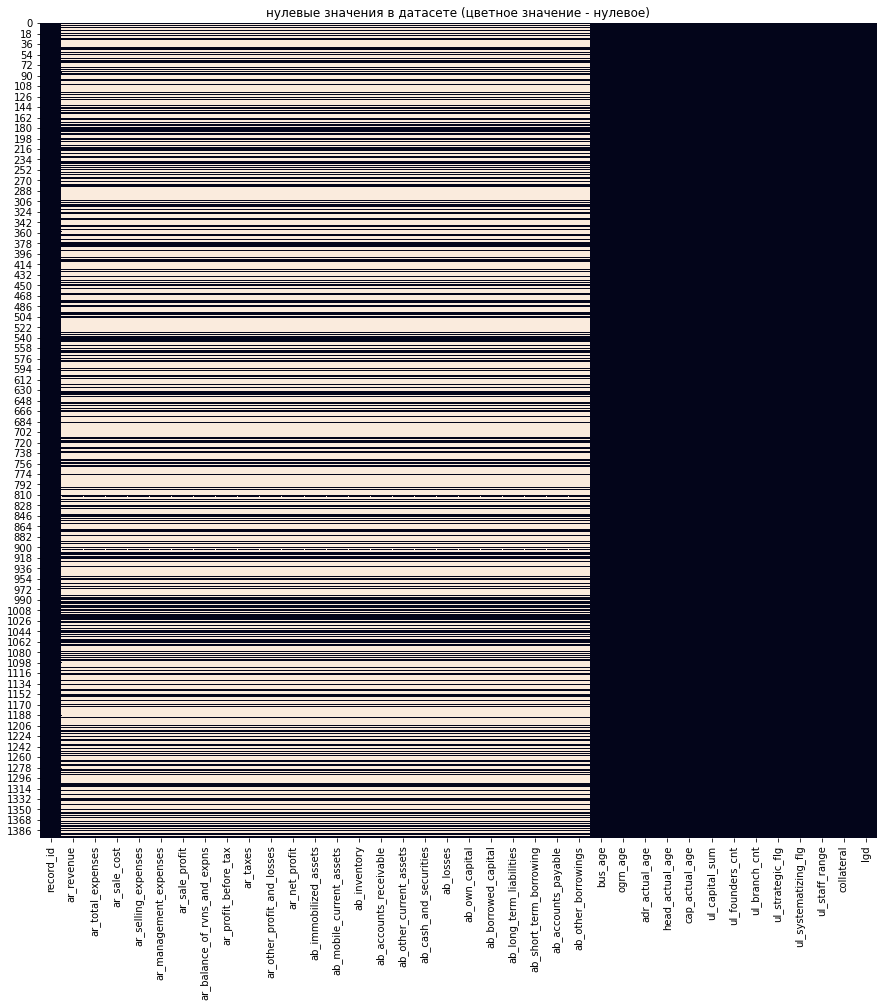

In [ ]:
plt.figure(figsize = (15, 15))
plt.title("нулевые значения в датасете (цветное значение - нулевое)")
plt.xlabel('значение в строке')
plt.ylabel('строка датасета')
sns.heatmap(train_df.isnull(), cbar=False)

In [ ]:
train_df.collateral.value_counts()[train_df.collateral.value_counts()!=train_df.collateral.value_counts()]

Series([], Name: collateral, dtype: int64)

In [ ]:
train_df.loc[:,'bus_age':'collateral'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bus_age               1400 non-null   int64  
 1   ogrn_age              1400 non-null   int64  
 2   adr_actual_age        1400 non-null   int64  
 3   head_actual_age       1400 non-null   int64  
 4   cap_actual_age        1400 non-null   int64  
 5   ul_capital_sum        1400 non-null   float64
 6   ul_founders_cnt       1400 non-null   int64  
 7   ul_branch_cnt         1400 non-null   int64  
 8   ul_strategic_flg      1400 non-null   int64  
 9   ul_systematizing_flg  1400 non-null   int64  
 10  ul_staff_range        1400 non-null   object 
 11  collateral            1400 non-null   object 
dtypes: float64(1), int64(9), object(2)
memory usage: 131.4+ KB


In [ ]:
train_df.loc[:,'bus_age':'ul_branch_cnt'].corr()

,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt
bus_age,1.000000,0.865256,0.145634,0.145634,0.145634,0.150170,0.147475,0.056533
ogrn_age,0.865256,1.000000,0.197052,0.197052,0.197052,0.115080,0.071795,0.068711
adr_actual_age,0.145634,0.197052,1.000000,1.000000,1.000000,-0.006047,0.068261,0.048457
head_actual_age,0.145634,0.197052,1.000000,1.000000,1.000000,-0.006047,0.068261,0.048457
cap_actual_age,0.145634,0.197052,1.000000,1.000000,1.000000,-0.006047,0.068261,0.048457
ul_capital_sum,0.150170,0.115080,-0.006047,-0.006047,-0.006047,1.000000,0.076775,-0.006479
ul_founders_cnt,0.147475,0.071795,0.068261,0.068261,0.068261,0.076775,1.000000,-0.002647
ul_branch_cnt,0.056533,0.068711,0.048457,0.048457,0.048457,-0.006479,-0.002647,1.000000


<AxesSubplot:>

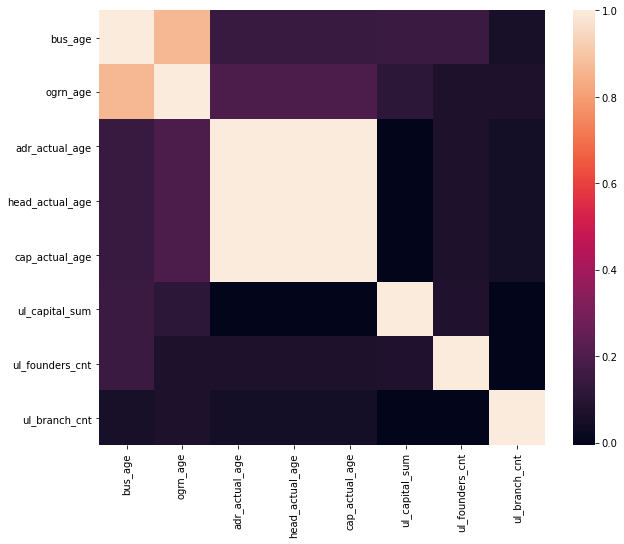

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.loc[:,'bus_age':'ul_branch_cnt'].corr())

In [ ]:
train_df['collateral']=train_df['collateral'].str.lower()
train_df['collateral']

0                      изгородь металлическая  
1                         нежилое помещение п4 
2                                        гараж 
3                          легковой автомобиль 
4                                        гараж 
                         ...                   
1395                                  квартира 
1396                             поручительство
1397    хозяйственно-бытовое здание (смпримеч) 
1398                       легковой автомобиль 
1399                                 хранилище 
Name: collateral, Length: 1400, dtype: object

### поскольку столбец "collateral" имеет кучу разных значений, в том числе имеющих схожий смысл, необходимо вручную провести энкодинг данных

In [ ]:
# ручной энкодинг залога
def zalog_enc(SET, df):
    mass=[]
    mass2={}
    list_of_ind=[]
    for k in range(len(SET)):
        for i in df['collateral'].index:

            if SET[k] in df['collateral'].iloc[i]:
                mass.append(i)
        mass2[SET[k]]=mass
        list_of_ind.append(mass)
        mass=[]

    return mass2, sum(list_of_ind, [])

для декодинга

In [ ]:
SET=[ 'квартира','квартиры','комната','жилое здание',  'авто', 'гараж', "ангар",
     'нежилое', 'мастерск',"здание", 'котельная',"дворец", "станци",
     "хранилище",'помещен', "строение", "общежитие", 'склад', 'корпус', 'медпункт', "пищеблок", 'столовая',
     'поликлиника','изолятор', 'морг', 'школа', 'бассейн', "насосная", "прачечная", "хозблок",
     "акушер","амбулатория", "контора", "сарай", "проходная", "веранда", "кпп",
     "топливо-раздаточный пункт","отделен", "номер",
     'поручительство']


l1=SET[0:4]
l2=[SET[4]]
l3=SET[5:7]
l4=SET[7:40]
l5=[SET[-1]]
l6=[]

print()


slovar, list_of_ind=zalog_enc(SET, train_df)


ser=train_df['collateral'].str.lower().copy()
out_ind=[]
for i in ser.index:
    if i not in list_of_ind:
        out_ind.append(i)
print(out_ind)

for i in out_ind:
    l6.append(str(ser[i]))


[0, 6, 22, 27, 30, 40, 46, 55, 98, 106, 151, 177, 224, 242, 279, 280, 281, 305, 321, 332, 350, 406, 427, 443, 467, 478, 495, 506, 529, 535, 538, 559, 582, 636, 642, 670, 701, 717, 756, 760, 794, 801, 819, 822, 834, 844, 905, 910, 913, 974, 995, 997, 1004, 1005, 1010, 1013, 1016, 1040, 1060, 1075, 1112, 1136, 1156, 1173, 1185, 1193, 1201, 1215, 1307, 1312, 1365, 1380]


In [ ]:
def enc(X, l, constant):
    for k in l:
        for i in X.index:
            if k in X.loc[i]:
                X.iloc[i]=str(constant)
    return X

In [ ]:
LIST=[l1,l2,l3,l4,l5,l6]
for n,mass in enumerate(LIST):
    ser=enc(ser,mass,n)
ser

0       5
1       3
2       2
3       1
4       2
       ..
1395    0
1396    4
1397    3
1398    1
1399    3
Name: collateral, Length: 1400, dtype: object

### для тестовой части

In [ ]:
SET=[ 'квартира','квартиры','комната','жилое здание',  'авто', 'гараж', "ангар",
     'нежилое', 'мастерск',"здание", 'котельная',"дворец", "станци",
     "хранилище",'помещен', "строение", "общежитие", 'склад', 'корпус', 'медпункт', "пищеблок", 'столовая',
     'поликлиника','изолятор', 'морг', 'школа', 'бассейн', "насосная", "прачечная", "хозблок",
     "акушер","амбулатория", "контора", "сарай", "проходная", "веранда", "кпп",
     "топливо-раздаточный пункт","отделен", "номер",
     'поручительство']


l1=SET[0:4]
l2=[SET[4]]
l3=SET[5:7]
l4=SET[7:40]
l5=[SET[-1]]
l6=[]

print()


slovar, list_of_ind=zalog_enc(SET, test_df)


ser_test=test_df['collateral'].str.lower().copy()
out_ind=[]
for i in ser_test.index:
    if i not in list_of_ind:
        out_ind.append(i)
print()

for i in out_ind:
    l6.append(str(ser_test[i]))

print(list_of_ind)



[11, 50, 68, 89, 90, 96, 108, 161, 170, 172, 179, 200, 221, 235, 283, 287, 298, 299, 307, 312, 317, 341, 375, 394, 408, 450, 454, 475, 480, 487, 493, 499, 507, 520, 521, 523, 524, 525, 539, 551, 570, 586, 591, 596, 643, 657, 680, 681, 1, 22, 23, 25, 35, 51, 53, 69, 73, 75, 81, 85, 98, 105, 111, 115, 118, 120, 122, 127, 128, 131, 146, 154, 156, 157, 159, 166, 169, 176, 181, 184, 189, 190, 193, 207, 208, 213, 215, 229, 233, 248, 249, 251, 259, 272, 274, 279, 280, 282, 286, 291, 292, 304, 306, 316, 319, 324, 331, 334, 338, 353, 356, 359, 360, 364, 379, 382, 391, 399, 403, 410, 414, 418, 421, 424, 431, 434, 453, 456, 459, 464, 479, 481, 486, 506, 509, 514, 527, 554, 559, 560, 562, 563, 574, 576, 577, 588, 599, 615, 619, 621, 629, 633, 648, 651, 654, 677, 678, 679, 687, 6, 19, 31, 32, 38, 47, 57, 61, 64, 67, 71, 74, 109, 114, 117, 135, 138, 142, 144, 151, 152, 168, 201, 204, 218, 224, 227, 241, 242, 246, 254, 257, 260, 262, 263, 265, 266, 269, 281, 284, 313, 314, 321, 327, 340, 343, 373, 

In [ ]:
LIST=[l1,l2,l3,l4,l5,l6]
for n,mass in enumerate(LIST):
    ser_test=enc(ser_test,mass,n)
ser_test

0      4
1      0
2      5
3      2
4      1
      ..
686    2
687    0
688    1
689    1
690    1
Name: collateral, Length: 691, dtype: object

In [ ]:
ser_test.value_counts()

1    211
0    206
2    103
4     61
3     55
5     55
Name: collateral, dtype: int64

In [ ]:
train_df['collateral']=ser
test_df['collateral']=ser_test
test_df['collateral']

0      4
1      0
2      5
3      2
4      1
      ..
686    2
687    0
688    1
689    1
690    1
Name: collateral, Length: 691, dtype: object

### Генерация фичей

#### исходя из названий столбцов данных в таблице с описанием, есть смысл сгруппировать данные через коэффициенты ликвидности и рентабельности

In [ ]:
train_df['abs_liq']=train_df['ab_cash_and_securities']/train_df['ab_short_term_borrowing']
train_df['fast_liq']=(train_df['ab_cash_and_securities']+train_df['ab_losses'])/(train_df['ab_short_term_borrowing']+train_df['ab_accounts_payable']+train_df['ab_other_borrowings'])
train_df['full_liq']=(train_df['ab_mobile_current_assets']+train_df['ab_mobile_current_assets'])/train_df['ab_short_term_borrowing']

In [ ]:
test_df['abs_liq']=test_df['ab_cash_and_securities']/test_df['ab_short_term_borrowing']
test_df['fast_liq']=(test_df['ab_cash_and_securities']+test_df['ab_losses'])/(test_df['ab_short_term_borrowing']+test_df['ab_accounts_payable']+test_df['ab_other_borrowings'])
test_df['full_liq']=(test_df['ab_mobile_current_assets']+test_df['ab_mobile_current_assets'])/test_df['ab_short_term_borrowing']

In [ ]:

train_df['RSK']=train_df['ar_net_profit']/train_df['ab_own_capital']
train_df['RZK']=train_df['ar_net_profit']/(train_df['ab_long_term_liabilities']+train_df['ab_short_term_borrowing'])
train_df['R_product']=train_df['ar_net_profit']/train_df['ar_sale_cost']
train_df['R']=train_df['ar_net_profit']/(train_df['ab_immobilized_assets']+train_df['ab_mobile_current_assets']+train_df['ab_inventory']+train_df['ab_other_current_assets'])

In [ ]:

test_df['RSK']=test_df['ar_net_profit']/test_df['ab_own_capital']
test_df['RZK']=test_df['ar_net_profit']/(test_df['ab_long_term_liabilities']+test_df['ab_short_term_borrowing'])
test_df['R_product']=test_df['ar_net_profit']/test_df['ar_sale_cost']
test_df['R']=test_df['ar_net_profit']/(test_df['ab_immobilized_assets']+test_df['ab_mobile_current_assets']+test_df['ab_inventory']+test_df['ab_other_current_assets'])

In [ ]:
desc_df.tail(6)

,field,desc_eng,desc_rus
29,ul_staff_range,The number of employees,Количество сотрудников
30,ul_capital_sum,Capital amount,Величина капитала
31,ul_founders_cnt,Number of shareholders,Количество акционеров
32,ul_branch_cnt,Number of branches,Количество филиалов
33,ul_strategic_flg,A company of strategic importance,Компания стратегического значения
34,ul_systematizing_flg,Backbone company,Системообразующая компания


In [ ]:
feat=['ab_own_capital','bus_age','adr_actual_age','ul_capital_sum', 
     'fast_liq','RSK','RZK','abs_liq','full_liq','R_product','R', 'collateral']
features = train_df[feat].fillna(0)
target = train_df[['lgd']]

In [ ]:
features

,ab_own_capital,bus_age,adr_actual_age,ul_capital_sum,fast_liq,RSK,RZK,abs_liq,full_liq,R_product,R,collateral
0,15061000.0,177,1,10000.0,0.207098,0.111746,0.598294,0.005332,15.329541,0.039447,0.067827,5
1,1224000.0,36,23,10000.0,0.193970,0.788399,0.536707,0.032258,7.163515,0.043736,0.087759,3
2,0.0,37,6,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,0.0,18,1,20000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.0,70,16,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.0,136,23,142500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1396,0.0,25,4,15625.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
1397,15442000.0,168,27,12000.0,0.112928,0.167724,0.146842,0.147919,8.556526,0.011677,0.021580,3
1398,51675000.0,97,23,85000.0,0.582847,0.101074,1.536176,0.020882,27.470588,0.093554,0.057068,1


### Анализ фичей по отдельности

In [ ]:
train_df, encod=encoding(train_df)

In [ ]:
a=train_df.loc[:,'bus_age':]
a, encoder_table=encoding(a)
a

,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,ul_staff_range,collateral,lgd,abs_liq,fast_liq,full_liq,RSK,RZK,R_product,R
0,177,142,1,1,1,10000.0,1,0,0,0,2,5,0.385417,0.005332,0.207098,15.329541,0.111746,0.598294,0.039447,0.067827
1,36,36,23,23,23,10000.0,1,0,0,0,2,3,0.371287,0.032258,0.193970,7.163515,0.788399,0.536707,0.043736,0.087759
2,37,37,6,6,6,10000.0,1,0,0,0,2,2,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18,18,1,1,1,20000.0,2,0,0,0,2,1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70,70,16,16,16,10000.0,1,0,0,0,2,2,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,136,136,23,23,23,142500.0,1,0,0,0,2,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1396,25,25,4,4,4,15625.0,2,0,0,0,2,4,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1397,168,137,27,27,27,12000.0,2,0,0,0,2,3,0.000000,0.147919,0.112928,8.556526,0.167724,0.146842,0.011677,0.021580
1398,97,97,23,23,23,85000.0,1,0,0,0,2,1,0.000000,0.020882,0.582847,27.470588,0.101074,1.536176,0.093554,0.057068


In [ ]:
a['collateral'].value_counts()

0    416
1    397
2    240
3    141
4    134
5     72
Name: collateral, dtype: int64

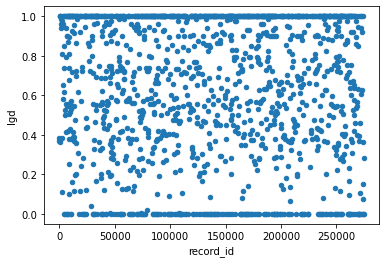

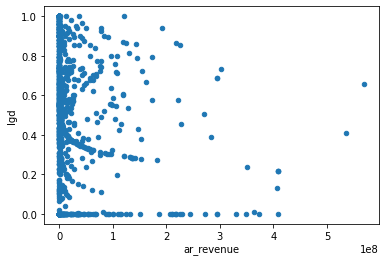

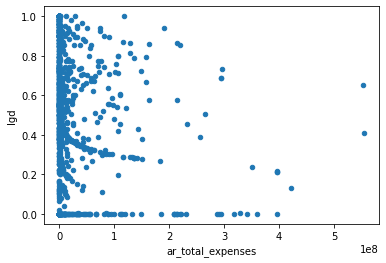

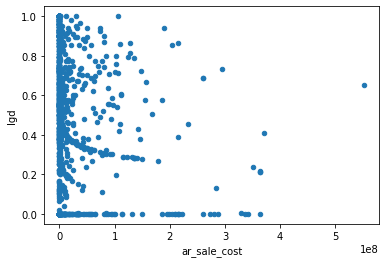

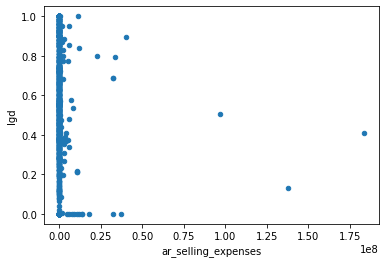

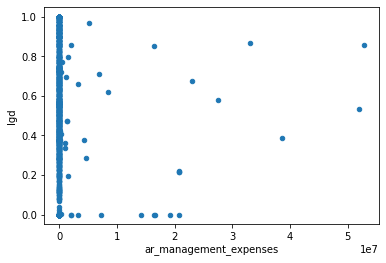

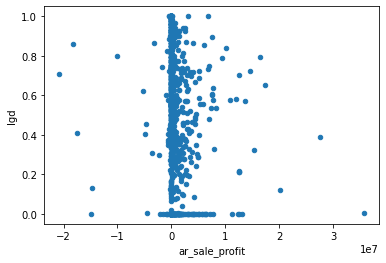

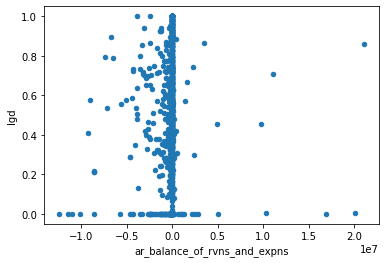

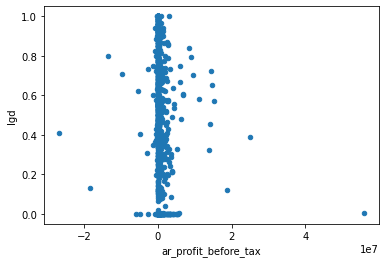

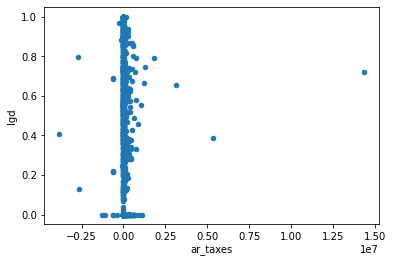

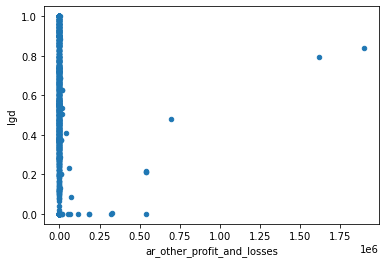

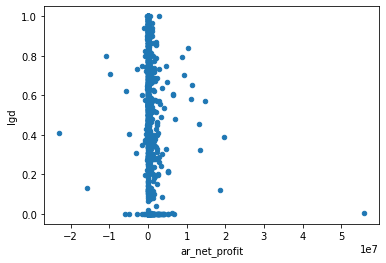

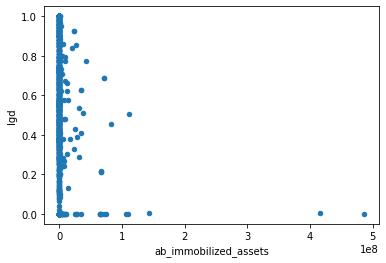

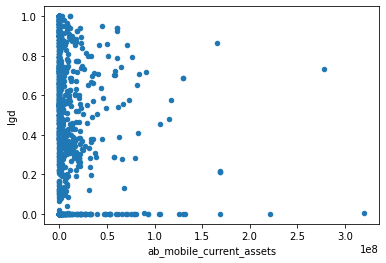

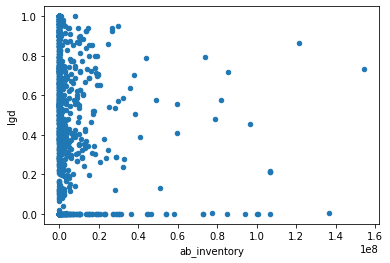

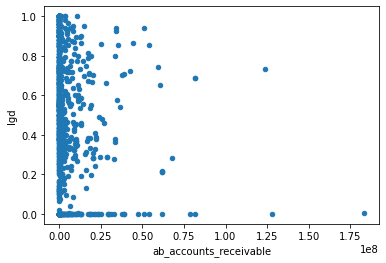

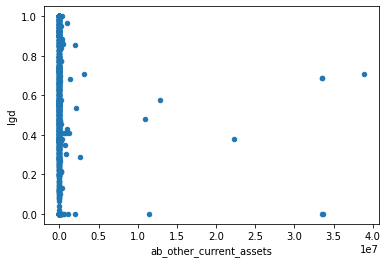

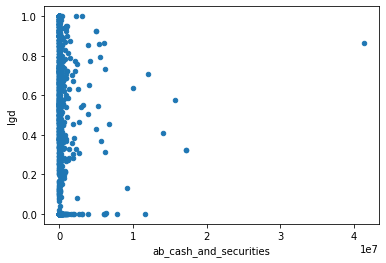

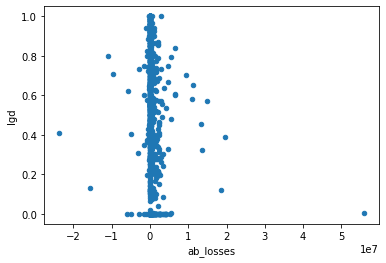

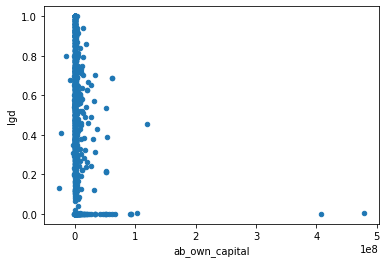

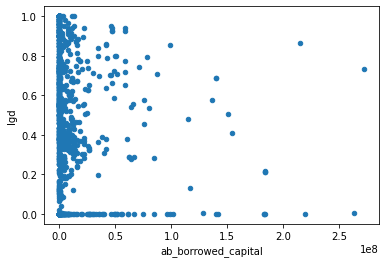

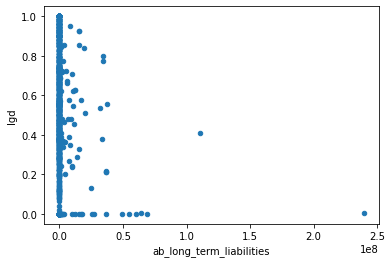

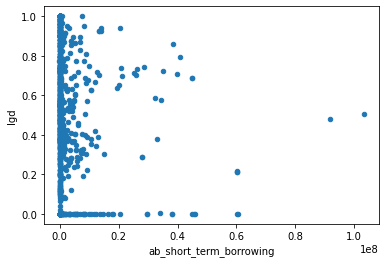

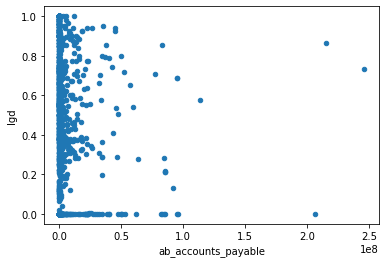

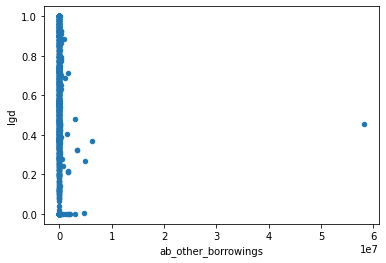

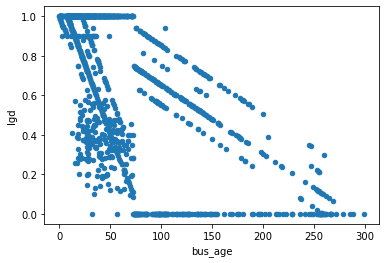

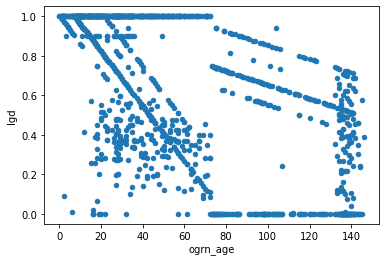

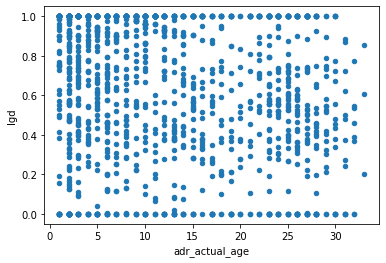

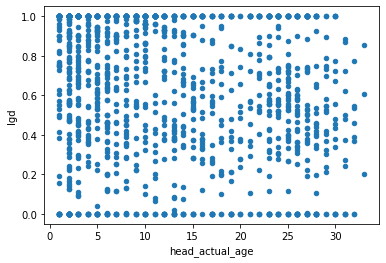

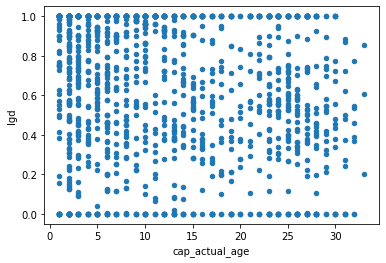

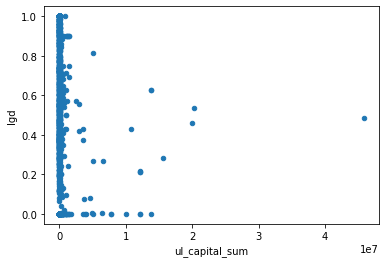

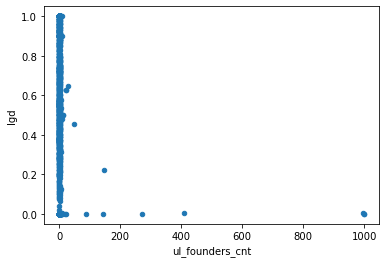

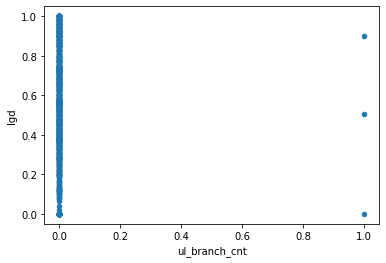

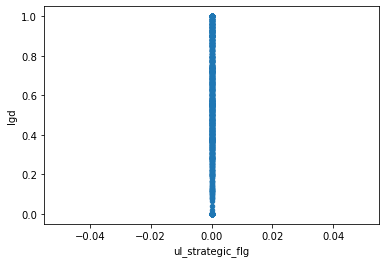

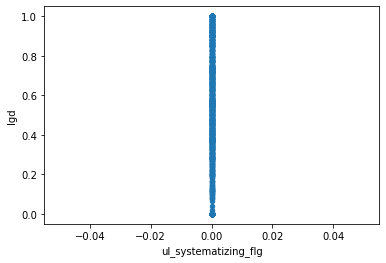

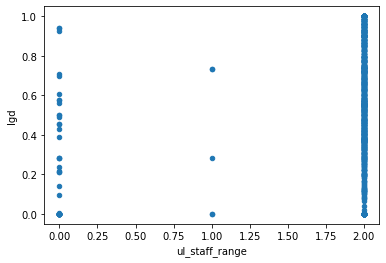

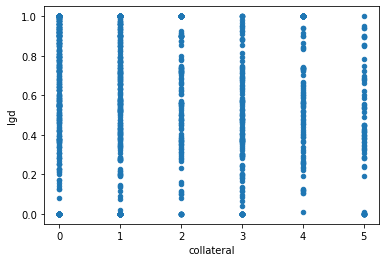

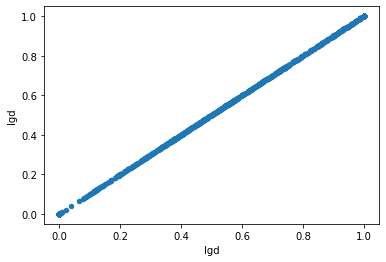

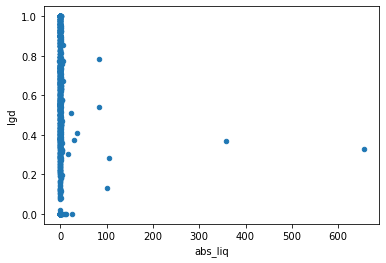

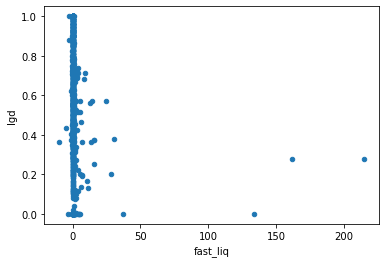

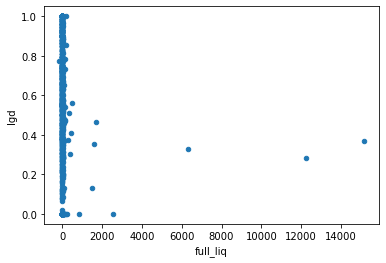

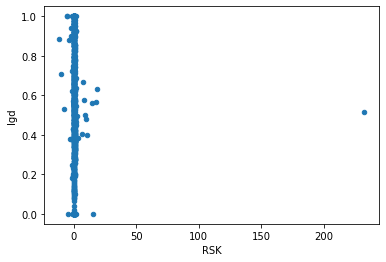

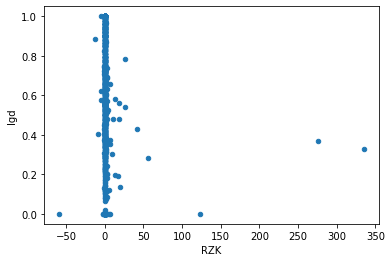

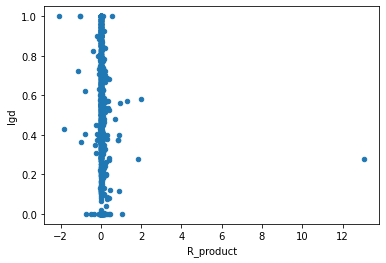

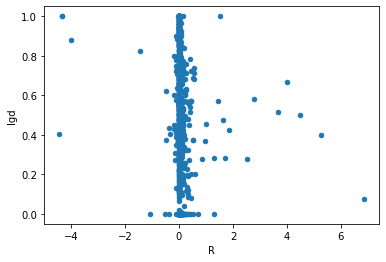

In [ ]:
for i in train_df.copy().fillna(0).columns:
    train_df.copy().fillna(0).plot(kind='scatter', x=i,y='lgd')

### Подготовка данных

In [ ]:
features, encoders=encoding(features)

In [ ]:
# избавление от бесконечностей
def anti_inf(f):
    for i in f.columns:
        f[i].loc[f[i][f[i]==np.inf].index]=f[i][f[i]!=np.inf].max()
        f[i].loc[f[i][f[i]==-np.inf].index]=f[i][f[i]!=-np.inf].min()
    return f

In [ ]:
features=anti_inf(features)
features

,ab_own_capital,bus_age,adr_actual_age,ul_capital_sum,fast_liq,RSK,RZK,abs_liq,full_liq,R_product,R,collateral
0,15061000.0,177,1,10000.0,0.207098,0.111746,0.598294,0.005332,15.329541,0.039447,0.067827,5
1,1224000.0,36,23,10000.0,0.193970,0.788399,0.536707,0.032258,7.163515,0.043736,0.087759,3
2,0.0,37,6,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,0.0,18,1,20000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.0,70,16,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.0,136,23,142500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1396,0.0,25,4,15625.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
1397,15442000.0,168,27,12000.0,0.112928,0.167724,0.146842,0.147919,8.556526,0.011677,0.021580,3
1398,51675000.0,97,23,85000.0,0.582847,0.101074,1.536176,0.020882,27.470588,0.093554,0.057068,1


In [ ]:
features.loc[[13,14]]

,ab_own_capital,bus_age,adr_actual_age,ul_capital_sum,fast_liq,RSK,RZK,abs_liq,full_liq,R_product,R,collateral
13,1761000.0,72,3,40000.0,0.299639,0.122658,335.0,655.5,15148.0,0.002807,0.054081,2
14,0.0,13,13,10000.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1


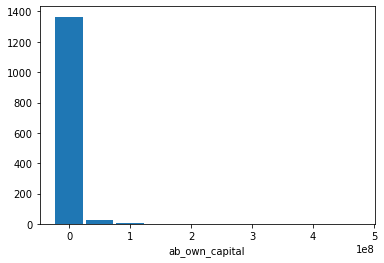

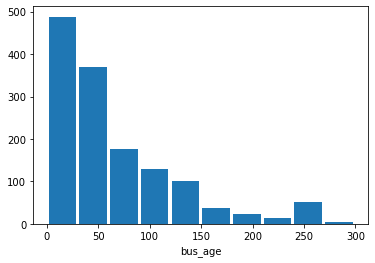

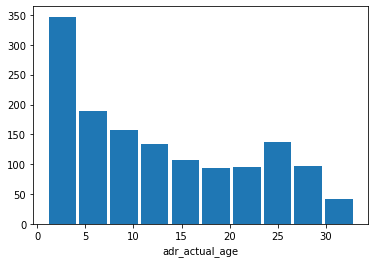

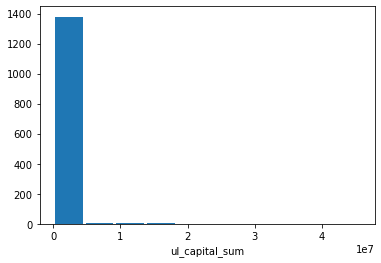

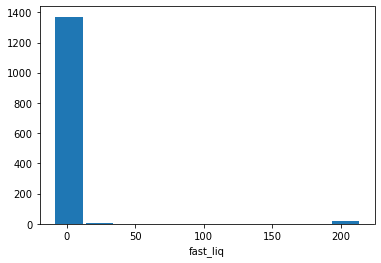

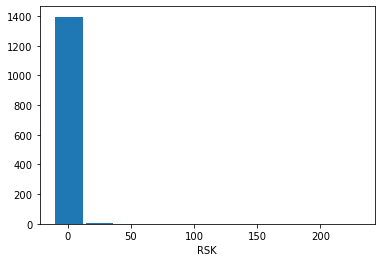

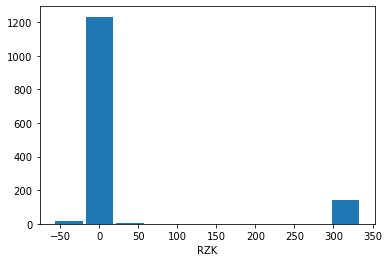

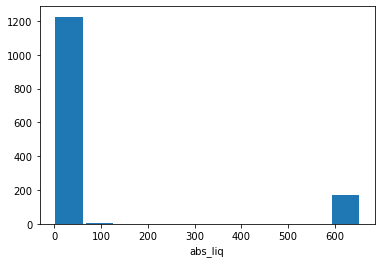

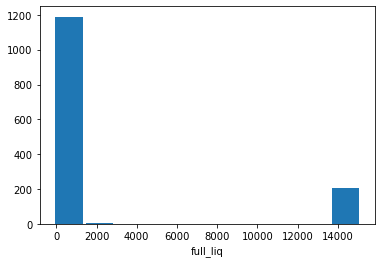

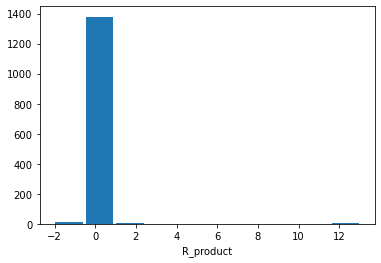

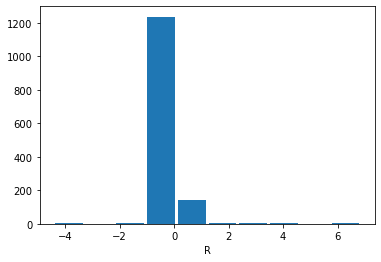

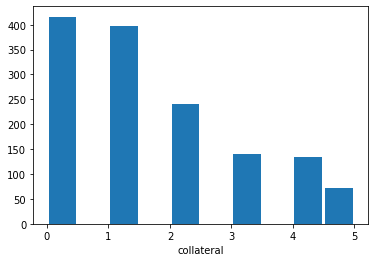

In [ ]:
for i in features.columns:
    plt.hist(features[i].values, histtype='bar', rwidth=0.9)
    plt.xlabel(i)
    plt.show()

In [ ]:
# для алгоритма отбора признаков
ff=features.copy()
tt=target.copy()

In [ ]:
from sklearn.model_selection import train_test_split
features, X_test, target, y_test = train_test_split(features, np.array(target), test_size=0.4, random_state=42)

In [ ]:
test_df['collateral']=test_df['collateral'].astype(np.int64)

In [ ]:
features_test = test_df[feat].fillna(0)
features_test

,ab_own_capital,bus_age,adr_actual_age,ul_capital_sum,fast_liq,RSK,RZK,abs_liq,full_liq,R_product,R,collateral
0,0.0,10,9,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
1,343000.0,39,2,11000.0,11.125000,0.970845,inf,inf,inf,0.048564,0.473011,0
2,-2230000.0,122,12,10000.0,0.091675,2.175785,-0.068151,1.141584,21.106228,-0.006424,-0.010527,5
3,0.0,34,23,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,0.0,16,13,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.0,92,4,27800.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
687,0.0,71,7,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
688,81000.0,28,28,10000.0,2.850000,0.839506,inf,inf,inf,inf,1.837838,1
689,0.0,110,19,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [ ]:
features_test=anti_inf(features_test)

In [ ]:
features_test

,ab_own_capital,bus_age,adr_actual_age,ul_capital_sum,fast_liq,RSK,RZK,abs_liq,full_liq,R_product,R,collateral
0,0.0,10,9,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
1,343000.0,39,2,11000.0,11.125000,0.970845,221.304428,23.416667,3940.588235,0.048564,0.473011,0
2,-2230000.0,122,12,10000.0,0.091675,2.175785,-0.068151,1.141584,21.106228,-0.006424,-0.010527,5
3,0.0,34,23,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,0.0,16,13,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.0,92,4,27800.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
687,0.0,71,7,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
688,81000.0,28,28,10000.0,2.850000,0.839506,221.304428,23.416667,3940.588235,1.858744,1.837838,1
689,0.0,110,19,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [ ]:
scaler=StandardScaler()

<AxesSubplot:>

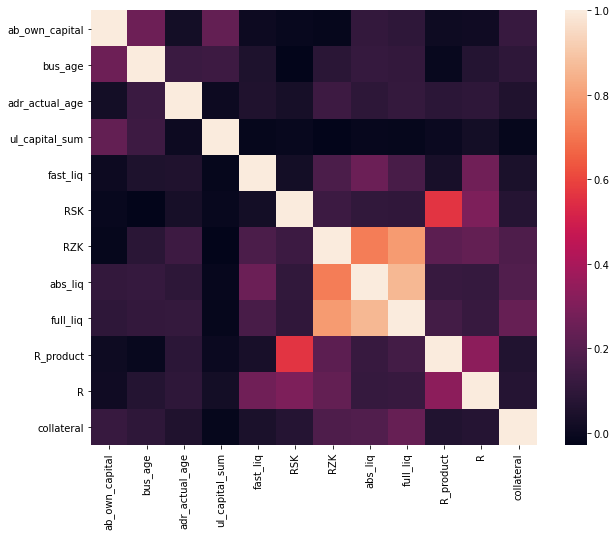

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(features.corr())

In [ ]:
features.columns

Index(['ab_own_capital', 'bus_age', 'adr_actual_age', 'ul_capital_sum',
       'fast_liq', 'RSK', 'RZK', 'abs_liq', 'full_liq', 'R_product', 'R',
       'collateral'],
      dtype='object')

### Отбор признаков алгоритмом add

#### суть алгоритма в переборе признаков и составлении выборки признаков, которая даст наилучший результат при обучении модели

In [ ]:
pre_feat=['ab_own_capital','bus_age','adr_actual_age','ul_capital_sum', 
         'fast_liq','RSK','RZK','abs_liq','full_liq','R', 'collateral','R_product']
feat=[]
feat_score=[100,100]
mid_feat=[]
while feat_score[-1]<=feat_score[-2]:
    for i in tqdm(pre_feat):
        feat_1=feat.copy()
        feat_1.append(str(i))
        feature = ff[feat_1]






        feature, X_test, targ, y_test = train_test_split(feature, np.array(tt), test_size=0.4, random_state=42)



        pipe_regr=Pipeline([('scaler', StandardScaler()), ('LinearRegression', LinearRegression())])
        pipe_regr.fit(np.array(feature), y=targ)
        mid_feat.append(mean_absolute_error(y_test, pipe_regr.predict(X_test)))
    feat.append(pre_feat[min(enumerate(mid_feat), key= lambda x: x[1])[0]])
    feat_score.append(round(min(enumerate(mid_feat), key= lambda x: x[1])[1],4))


    pre_feat.remove(pre_feat[min(enumerate(mid_feat), key= lambda x: x[1])[0]])


       
    mid_feat.clear()
    
print(feat)
print(feat_score)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['bus_age', 'full_liq', 'collateral', 'adr_actual_age', 'R', 'RZK', 'ul_capital_sum', 'RSK', 'ab_own_capital', 'abs_liq', 'fast_liq']
[100, 100, 0.2391, 0.2268, 0.2233, 0.2218, 0.221, 0.2205, 0.2203, 0.2203, 0.2203, 0.2203, 0.2204]


In [ ]:
features_test = test_df[feat[:-1]].fillna(0)
features_test=anti_inf(features_test)

In [ ]:
features=ff[feat[:-1]]
features

,bus_age,full_liq,collateral,adr_actual_age,R,RZK,ul_capital_sum,RSK,ab_own_capital,abs_liq
0,177,15.329541,5,1,0.067827,0.598294,10000.0,0.111746,15061000.0,0.005332
1,36,7.163515,3,23,0.087759,0.536707,10000.0,0.788399,1224000.0,0.032258
2,37,0.000000,2,6,0.000000,0.000000,10000.0,0.000000,0.0,0.000000
3,18,0.000000,1,1,0.000000,0.000000,20000.0,0.000000,0.0,0.000000
4,70,0.000000,2,16,0.000000,0.000000,10000.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
1395,136,0.000000,0,23,0.000000,0.000000,142500.0,0.000000,0.0,0.000000
1396,25,0.000000,4,4,0.000000,0.000000,15625.0,0.000000,0.0,0.000000
1397,168,8.556526,3,27,0.021580,0.146842,12000.0,0.167724,15442000.0,0.147919
1398,97,27.470588,1,23,0.057068,1.536176,85000.0,0.101074,51675000.0,0.020882


In [ ]:
tt.shape

(1400, 1)

In [ ]:
features, X_test, target, y_test = train_test_split(features, np.array(tt), test_size=0.4, random_state=42)

In [ ]:
features.shape

(840, 10)

### Моделирование деревом

In [ ]:
dtree = DecisionTreeRegressor(random_state=1, max_depth=2)
dtree.fit(features,target)
'''dot_data = StringIO()
export_graphviz(dtree, 
                out_file = dot_data, 
                feature_names = list(features.columns),
                filled = True, 
                rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())'''

'dot_data = StringIO()\nexport_graphviz(dtree, \n                out_file = dot_data, \n                feature_names = list(features.columns),\n                filled = True, \n                rounded = True,\n                special_characters = True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())'

In [ ]:
mean_absolute_error(target, dtree.predict(features))

0.19045277354343737

Метрика качества МАЕ при моделировании деревом = 25,74%

### Моделирование (регрессия)

In [ ]:
pipe_regr=Pipeline([('scaler', StandardScaler()), ('LinearRegression', LinearRegression())])
pipe_regr.fit(np.array(features), y=target)
mean_absolute_error(y_test, pipe_regr.predict(X_test))

0.22032046312784745

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
from sklearn.model_selection import cross_val_score
clf = Pipeline([('scaler', StandardScaler()), ('LinearRegression', LinearRegression())])
scores = cross_val_score(clf, np.array(ff[feat[:-1]]), np.array(tt), cv=5, scoring='neg_mean_absolute_error')
scores

array([-0.23324389, -0.22041756, -0.24499244, -0.22476405, -0.20674379])

### PCA

In [ ]:
pca = PCA(n_components=3)
pca.fit_transform(ff[feat[:-1]])

array([[ 1.23542138e+07, -5.21336832e+05, -2.43391792e+03],
       [-1.47989953e+06, -2.38710493e+05, -2.22461368e+03],
       [-2.70364418e+06, -2.13709796e+05, -2.21253555e+03],
       ...,
       [ 1.27351752e+07, -5.27119329e+05, -2.44660155e+03],
       [ 4.89621073e+07, -1.19420829e+06, -2.99451031e+03],
       [-1.29191833e+06, -2.41550678e+05, -2.22359902e+03]])

In [ ]:
XX=np.hstack([np.array(ff[feat[:-1]]),pca.fit_transform(ff[feat[:-1]])])

In [ ]:

clf = Pipeline([('scaler', StandardScaler()), ('LinearRegression', LinearRegression())])
scores = cross_val_score(clf, XX, np.array(tt), cv=5, scoring='neg_mean_absolute_error')
scores

array([-0.23324389, -0.21962119, -0.24499244, -0.22476405, -0.20674379])

Метрика качества МАЕ при моделировании регрессией = 23,71%

### Pytorch

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms

In [ ]:
X = torch.autograd.Variable(torch.FloatTensor(scale(features)))
y = torch.autograd.Variable(torch.FloatTensor(np.array(target)))

In [ ]:
# input dim
H=X.shape[1]

In [ ]:
Xt = torch.autograd.Variable(torch.FloatTensor(scale(X_test)))
yt = torch.autograd.Variable(torch.FloatTensor(y_test))

In [ ]:
Xf = torch.autograd.Variable(torch.FloatTensor(scale(features_test)))


In [ ]:
dataset = torch.utils.data.TensorDataset(X, y)
dataset_test = torch.utils.data.TensorDataset(Xt, yt)

In [ ]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=3, num_layers=0,
                hidden_dim=200, output_dim=1, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers=torch.nn.Sequential()
        
        prev_size=input_dim
        for i in range(num_layers):
            self.layers.add_module('batch_norm{}'.format(i),
                                  torch.nn.BatchNorm1d(prev_size))
            self.layers.add_module('layer {}'.format(i),
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('Prelu {}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout {}'.format(i), torch.nn.Dropout(p=p))
            prev_size=hidden_dim
        
        self.layers.add_module('regression', torch.nn.Linear(prev_size, output_dim))
        
        self.to(device)
    
    def forward(self, input):
        return self.layers(input)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model=Perceptron(input_dim=H, num_layers=3, device=device, p=0.2)
model

Perceptron(
  (layers): Sequential(
    (batch_norm0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer 0): Linear(in_features=10, out_features=200, bias=True)
    (Prelu 0): ReLU()
    (dropout 0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer 1): Linear(in_features=200, out_features=200, bias=True)
    (Prelu 1): ReLU()
    (dropout 1): Dropout(p=0.2, inplace=False)
    (batch_norm2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer 2): Linear(in_features=200, out_features=200, bias=True)
    (Prelu 2): ReLU()
    (dropout 2): Dropout(p=0.2, inplace=False)
    (regression): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [ ]:
def testing(model, dataset):
    generator=torch.utils.data.DataLoader(dataset, batch_size=64)
    
    pred=[]
    real=[]
    
    for x,y in tqdm(generator, leave=False):
        x=x.to(device)
        y=y.to(device)
        
        pred.extend(model(x).cpu().detach().numpy().tolist())
        real.extend(y.cpu().detach().numpy().tolist())
    
    return print(mean_absolute_error(pred, real))

In [ ]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator=torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        
        for x,y in tqdm(generator, leave=False):
            x=x.to(device)
            y=y.to(device)
            output = model(x)
            loss= loss_function(output, y)
            loss.backward()
            optimizer.step()

In [ ]:
_ =model.train()
trainer(model=model, dataset=dataset, loss_function=torch.nn.MSELoss(),
       optimizer=torch.optim.Adam(model.parameters(), lr=0.0001), epochs = 45)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
_ =model.eval()
testing(model=model, dataset=dataset_test)

  0%|          | 0/9 [00:00<?, ?it/s]

0.4173033248217377


In [ ]:
for p in np.linspace(0,0.7,8):
    model=Perceptron(input_dim=H,num_layers=2, device=device, p=p)
    _ =model.train()
    trainer(model=model, dataset=dataset, loss_function=torch.nn.MSELoss(),
           optimizer=torch.optim.Adam(model.parameters(), lr=0.00001), epochs = 45)
    _ =model.eval()
    testing(model=model, dataset=dataset_test)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.23930736074523468


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.3462176915075231


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.20825726910427744


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.3353777349410978


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.2410366463358514


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.25618019752603555


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.21434988124695206


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0.2116809279957254


In [ ]:
model=Perceptron(input_dim=H, num_layers=6, device=device, p=0.2)
_ =model.train()
trainer(model=model, dataset=dataset, loss_function=torch.nn.MSELoss(),
       optimizer=torch.optim.Adam(model.parameters(), lr=0.00001), epochs = 45)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
_ =model.eval()
testing(model=model, dataset=dataset_test)

  0%|          | 0/9 [00:00<?, ?it/s]

0.2906221466687774


In [ ]:
model(Xf).shape

torch.Size([691, 1])

### SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [ ]:
svr=SVR()
SVR_grid={'kernel':['rbf', 'sigmoid'],#'linear', 'poly', 
         'degree':[1,2], #,3
         'C':[0.2, 0.01]} #,0.5, 0, 1,2

In [ ]:
gs = GridSearchCV(svr, SVR_grid, cv=5)
gs.fit(features, target.ravel())

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.2, 0.01], 'degree': [1, 2],
                         'kernel': ['rbf', 'sigmoid']})

In [ ]:
C_best=gs.best_params_['C']
d_best=gs.best_params_['degree']
k_best=gs.best_params_['kernel']

In [ ]:
C_best, d_best, k_best

(0.2, 1, 'rbf')

In [ ]:
svr=SVR(C=C_best, kernel=k_best, degree=d_best)

In [ ]:
svr.fit(np.array(features), target.ravel())

SVR(C=0.2, degree=1)

In [ ]:
mean_absolute_error(svr.predict(np.array(X_test)), y_test)

0.28006136713293117

In [ ]:
import scipy

#### создадим ядро вручную

In [ ]:
def kernel(X1, X2):
    return np.exp(-0.05*cdist(X1, X2)**2)

In [ ]:
svr=SVR(C=C_best, kernel=kernel, degree=d_best)

In [ ]:
svr.fit(features, target.ravel())

SVR(C=0.2, degree=1, kernel=<function kernel at 0x7fcba22868b0>)

In [ ]:
mean_absolute_error(svr.predict(X_test), y_test)

0.24137162618370078

In [ ]:
X_train_new = np.hstack([kernel(np.array(features), np.array(features)[svr.support_]), np.array(features)])

In [ ]:
X_test_new = np.hstack([kernel(np.array(X_test), np.array(features)[svr.support_]), np.array(X_test)])

In [ ]:
X_train_new.shape

(840, 615)

In [ ]:
svr=SVR(C=C_best, kernel=kernel, degree=d_best)

In [ ]:
svr.fit(X_train_new, target.ravel())

SVR(C=0.2, degree=1, kernel=<function kernel at 0x7fcba22868b0>)

In [ ]:
mean_absolute_error(svr.predict(X_test_new), y_test)

0.2419264046793362

### Submit

добавим полученные значения модели SVM в виде признаков в новую модель для SVM

kernel(features_test, features.iloc[svr.support_]).shape

test = np.hstack([kernel(features_test, features.iloc[svr.support_]), features_test])

test.shape

### делаем предсказание на основе любой из моделей

In [ ]:
predict = svr.predict(features_test)

In [ ]:
predict = model(Xf).detach().numpy()

In [ ]:
predict = pipe_regr.predict(features_test)

In [ ]:
predict = dtree.predict(features_test)

### Формируем отчёт

In [ ]:
sumbit_df = test_df[['record_id']].copy()

In [ ]:
sumbit_df['predict'] = predict

In [ ]:
sumbit_df['predict'].values.mean()

0.6427533011656684

Среднее значение предсказанного LGD в тестовой выборке 64,08%

In [ ]:
sumbit_df.rename({'record_id':'id'},axis=1,inplace=True)

In [ ]:
sumbit_df.head()

,id,predict
0,578,0.909840
1,815,0.651763
2,1049,0.514496
3,1249,0.769229
4,1370,0.840139


Формируем submit файл

In [ ]:
sumbit_df.to_csv('LGD-submit.csv', index=False)